In [1]:
from pyspark import SparkContext
from pyspark.sql import SQLContext


In [1]:
from pyspark.sql import SparkSession

# Spark session & context
spark = SparkSession.builder.enableHiveSupport().getOrCreate()

In [2]:
sc = SparkContext()
sqlContext = SQLContext(sc)

In [2]:
df = spark.read.option("header",True).csv("/user/arnavmoutl12edu/module8/titanic.csv")

In [6]:
df.show(10)

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|  22|    1|    0|       A/5 21171|   7.25| null|       S|
|          2|       1|     1|Cumings, Mrs. Joh...|female|  38|    1|    0|        PC 17599|71.2833|  C85|       C|
|          3|       1|     3|Heikkinen, Miss. ...|female|  26|    0|    0|STON/O2. 3101282|  7.925| null|       S|
|          4|       1|     1|Futrelle, Mrs. Ja...|female|  35|    1|    0|          113803|   53.1| C123|       S|
|          5|       0|     3|Allen, Mr. Willia...|  male|  35|    0|    0|          373450|   8.05| null|       S|
|          6|       0|     3|    Moran, Mr. James|  male|null|    0|    0|      

In [7]:
df.printSchema()

root
 |-- PassengerId: string (nullable = true)
 |-- Survived: string (nullable = true)
 |-- Pclass: string (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- SibSp: string (nullable = true)
 |-- Parch: string (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: string (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)



In [15]:
from pyspark.sql.types import IntegerType
data_df = df.withColumn("Survived", df["Survived"].cast(IntegerType()))
data_df = data_df.withColumn("Age", data_df["Age"].cast(IntegerType()))

In [11]:
data_df.printSchema()

root
 |-- PassengerId: string (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: string (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- SibSp: string (nullable = true)
 |-- Parch: string (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: integer (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)



In [8]:
from pyspark.sql.functions import col,isnan, when, count

In [21]:
df_no_na.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in data_df.columns]).show()

+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|PassengerId|Survived|Pclass|Name|Sex|Age|SibSp|Parch|Ticket|Fare|Cabin|Embarked|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|          0|       0|     0|   0|  0|  0|    0|    0|     0|   0|  529|       2|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+



In [20]:
df_no_na = data_df.na.drop(subset=["Age"])

In [13]:
from pyspark.ml.feature import VectorAssembler

In [23]:
vecAssembler = VectorAssembler(inputCols=["Survived", "Age"], outputCol="features")
new_df = vecAssembler.transform(df_no_na)
new_df.show(10)

+-----------+--------+------+--------------------+------+---+-----+-----+----------------+-------+-----+--------+----------+
|PassengerId|Survived|Pclass|                Name|   Sex|Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|  features|
+-----------+--------+------+--------------------+------+---+-----+-----+----------------+-------+-----+--------+----------+
|          1|       0|     3|Braund, Mr. Owen ...|  male| 22|    1|    0|       A/5 21171|   7.25| null|       S|[0.0,22.0]|
|          2|       1|     1|Cumings, Mrs. Joh...|female| 38|    1|    0|        PC 17599|71.2833|  C85|       C|[1.0,38.0]|
|          3|       1|     3|Heikkinen, Miss. ...|female| 26|    0|    0|STON/O2. 3101282|  7.925| null|       S|[1.0,26.0]|
|          4|       1|     1|Futrelle, Mrs. Ja...|female| 35|    1|    0|          113803|   53.1| C123|       S|[1.0,35.0]|
|          5|       0|     3|Allen, Mr. Willia...|  male| 35|    0|    0|          373450|   8.05| null|       S|[0.0,35.0]|


In [24]:
from pyspark.ml.clustering import KMeans

In [25]:
kmeans = KMeans(k=3, seed=1)  # 2 clusters here
model = kmeans.fit(new_df.select('features'))

In [26]:
transformed = model.transform(new_df)
transformed.show()

+-----------+--------+------+--------------------+------+---+-----+-----+----------------+-------+-----+--------+----------+----------+
|PassengerId|Survived|Pclass|                Name|   Sex|Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|  features|prediction|
+-----------+--------+------+--------------------+------+---+-----+-----+----------------+-------+-----+--------+----------+----------+
|          1|       0|     3|Braund, Mr. Owen ...|  male| 22|    1|    0|       A/5 21171|   7.25| null|       S|[0.0,22.0]|         2|
|          2|       1|     1|Cumings, Mrs. Joh...|female| 38|    1|    0|        PC 17599|71.2833|  C85|       C|[1.0,38.0]|         0|
|          3|       1|     3|Heikkinen, Miss. ...|female| 26|    0|    0|STON/O2. 3101282|  7.925| null|       S|[1.0,26.0]|         2|
|          4|       1|     1|Futrelle, Mrs. Ja...|female| 35|    1|    0|          113803|   53.1| C123|       S|[1.0,35.0]|         2|
|          5|       0|     3|Allen, Mr. Willia..

In [28]:
transformed.printSchema()

root
 |-- PassengerId: string (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: string (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- SibSp: string (nullable = true)
 |-- Parch: string (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: string (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)
 |-- features: vector (nullable = true)
 |-- prediction: integer (nullable = false)



In [31]:
from pyspark.sql.functions import mean, min, max, sum
result = transformed.groupby('prediction').agg(mean("Age"), min("Age"), max("Age"), sum("Survived"), count("Survived"))
result.show()

+----------+------------------+--------+--------+-------------+---------------+
|prediction|          avg(Age)|min(Age)|max(Age)|sum(Survived)|count(Survived)|
+----------+------------------+--------+--------+-------------+---------------+
|         1| 8.991150442477876|       0|      17|           61|            113|
|         2|26.716707021791766|      18|      37|          158|            413|
|         0| 48.62234042553192|      38|      80|           71|            188|
+----------+------------------+--------+--------+-------------+---------------+



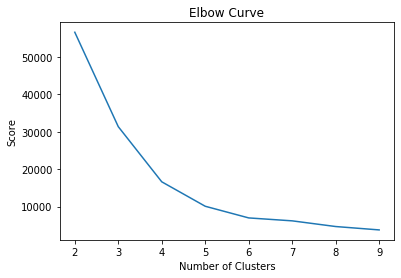

In [34]:
import pandas as pd, numpy as np

# Calculate cost and plot
cost = np.zeros(10)

for k in range(2,10):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol('features')
    model = kmeans.fit(new_df)
    cost[k] = model.summary.trainingCost


# Plot the cost
df_cost = pd.DataFrame(cost[2:])
df_cost.columns = ["cost"]
new_col = [2,3,4,5,6,7,8, 9]
df_cost.insert(0, 'cluster', new_col)

import pylab as pl
pl.plot(df_cost.cluster, df_cost.cost)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

In [10]:
df.select('lat', 'long').rdd.collect()

[Row(lat=33.3, long=-17.5),
 Row(lat=40.4, long=-20.5),
 Row(lat=28.0, long=-23.9),
 Row(lat=29.5, long=-19.0),
 Row(lat=32.8, long=-18.84)]

In [11]:
df.select('lat', 'long').rdd.map(lambda x: (x[0], x[1])).collect()

[(33.3, -17.5), (40.4, -20.5), (28.0, -23.9), (29.5, -19.0), (32.8, -18.84)]

In [12]:
from pyspark.mllib.clustering import KMeans, KMeansModel

rdd = df.select('lat', 'long').rdd.map(lambda x: (x[0], x[1]))
clusters = KMeans.train(rdd, 2, maxIterations=10, initializationMode="random")

In [13]:
clusters.centers

[array([ 34.  , -18.96]), array([ 28. , -23.9])]

In [25]:
sc.stop()